# SVM

In [6]:

import pandas as pd
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
import re
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
tqdm.pandas()



## Step 1 : Load data_train, test, submission

1. Read data (train, test and submission)
2. Keep only (TextID, text and sentiment)
3. Store sentiements (negative, positive and neutral)

In [7]:
data_train = pd.read_csv('data/train.csv').fillna('')
data_test = pd.read_csv('data/test.csv').fillna('')
submission = pd.read_csv('data/sample_submission.csv')

df_list = [data_train[['textID', 'text', 'sentiment']], data_test]
df_list = pd.concat(df_list, ignore_index=True)
print(df_list[1:])

sentiments = df_list['sentiment'].unique()
print("3 sentiments : ", sentiments)


           textID                                               text sentiment
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2      088c60f138                          my boss is bullying me...  negative
3      9642c003ef                     what interview! leave me alone  negative
4      358bd9e861   Sons of ****, why couldn`t they put them on t...  negative
5      28b57f3990  http://www.dothebouncy.com/smf - some shameles...   neutral
...           ...                                                ...       ...
31010  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative
31011  416863ce47  All alone in this old house again.  Thanks for...  positive
31012  6332da480c   I know what you mean. My little dog is sinkin...  negative
31013  df1baec676  _sutra what is your next youtube video gonna b...  positive
31014  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[31014 rows x 3 columns]
3 sentiments :  ['neutral'

# ...

## Clean data

1. clean data
2. tokenize

In [8]:
import string
punctuations_list = string.punctuation

def clean_data(text):
    # remove links
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    # remove words that have numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', "", text)
    # remove HTML tags
    text = re.sub(r'<.*?>', "", text)
    # remove ponctuation
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df_list['text'] = df_list['text'].str.lower()
df_list['text'] = list(clean_data(x) for x in df_list['text'])

# tokenizer = RegexpTokenizer(r'\w+')
# df_list['text'] =df_list['text'].apply(tokenizer.tokenize)
# print(df_list['text'])


## Remonving Stop Word

In [9]:

file = open('data/stop-words_english_2_en.txt').read()
stopwords =  set(file[3:].split("\n"))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])
    
df_list['text'] = df_list['text'].apply(lambda text: cleaning_stopwords(text))

## Convert sentiment 

Positive -> 1 /
Negative -> -1 /
Neutral -> 0 

In [10]:
def sentiment2target(sentiment):
    return {
        'negative': -1,
        'neutral': 0,
        'positive' : 1
    }[sentiment]
df_list['sentiment'] = df_list['sentiment'].apply(sentiment2target)
print(df_list['sentiment'])

0        0
1       -1
2       -1
3       -1
4       -1
        ..
31010   -1
31011    1
31012   -1
31013    1
31014    1
Name: sentiment, Length: 31015, dtype: int64


## Vactorizing the data

1. Split our data into train and test
2. Transforme data using idf and df vetorse

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_list['text'], df_list['sentiment'], test_size = 0.05, random_state =26105111)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(iter(X_train))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# data_train_index = X_train[:,0]
# data_train = X_train[:,1:]
# data_test_index = X_test[:,0]
# data_test = X_test[:,1:]


C:\Users\kawte\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  166686


 # Linear SVM classifier

1. On remarque que notre modèle est très performant, les scores trouvés pour la (neg, pos et neutral) sont equilibré. 
La précision globale du modèle est de 69%. La performance du modèle est exemplaire.

2. La figure ci-dessous montre une matrice de confusion pour le modèle SVM ROS. Les valeurs sont très elevés.
Le modèle reconnait plus de modèle positives

              precision    recall  f1-score   support

          -1       0.65      0.62      0.64       426
           0       0.65      0.66      0.66       647
           1       0.73      0.75      0.74       478

    accuracy                           0.68      1551
   macro avg       0.68      0.68      0.68      1551
weighted avg       0.68      0.68      0.68      1551



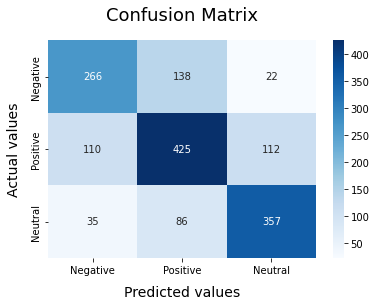

In [12]:
# Model evaluation

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive', 'Neutral']
    group_names = ['True Neg','False Pos', 'False Neu', 'False Neg', 'True Pos', 'True Neu']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)


## Curve (ROC AUC)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Why ? 

Confusion Matrix allows us to measure Recall, Precision,

Accuracy and AUC-ROC curve are the metrics to measure the performance of the model.